In [1]:
# inode full error

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *
import ast

In [6]:
NUM_SAMPLES_PER_CLASS = 100000
NUM_VAL = 50 * 340

In [7]:
PATH = Path('../data/quickdraw/')

In [8]:
PATH.ls()

[PosixPath('../data/quickdraw/test_simplified.csv'),
 PosixPath('../data/quickdraw/train'),
 PosixPath('../data/quickdraw/submission'),
 PosixPath('../data/quickdraw/train_folders')]

### create folder data

In [9]:
dfs_combined = pd.read_csv(PATH/"train/dfs_combined.csv")
test_df = pd.read_csv(PATH/"test_simplified.csv")

In [10]:
dfs_combined = dfs_combined[['drawing', 'word']]

In [11]:
classes = dfs_combined['word'].unique()

In [12]:
os.makedirs(PATH/"train_folders", exist_ok=True)

In [29]:
NUM_SAMPLES = 70000
for c in ['wine_bottle', 'tent', 'zebra', 't-shirt']:
    print(c)
    folder_name = c.replace(" ", "_")
    os.makedirs(PATH/f"train_folders/{folder_name}", exist_ok=True)
    drawings = dfs_combined[dfs_combined['word'] == c]["drawing"].values
    for i, drawing in enumerate(drawings[:NUM_SAMPLES]):
        with open(PATH/f"train_folders/{folder_name}/sample_{i}", mode="w+") as f:
            f.write(drawing)

wine_bottle
tent
zebra
t-shirt


###  Create ImageDataBunch using the data block API

In [70]:
bs = 700
sz = 256

In [35]:
idxs = list(range(dfs_combined.shape[0]))

In [36]:
i = np.random.choice(idxs)
input_ = dfs_combined.loc[i, 'drawing']
cls = dfs_combined.loc[i, 'word']; print(cls)

camel


In [37]:
input_list = eval(input_); len(input_list)

10

In [38]:
parts = list2multichannel(input_list)

In [39]:
parts.shape

(6, 256, 256)

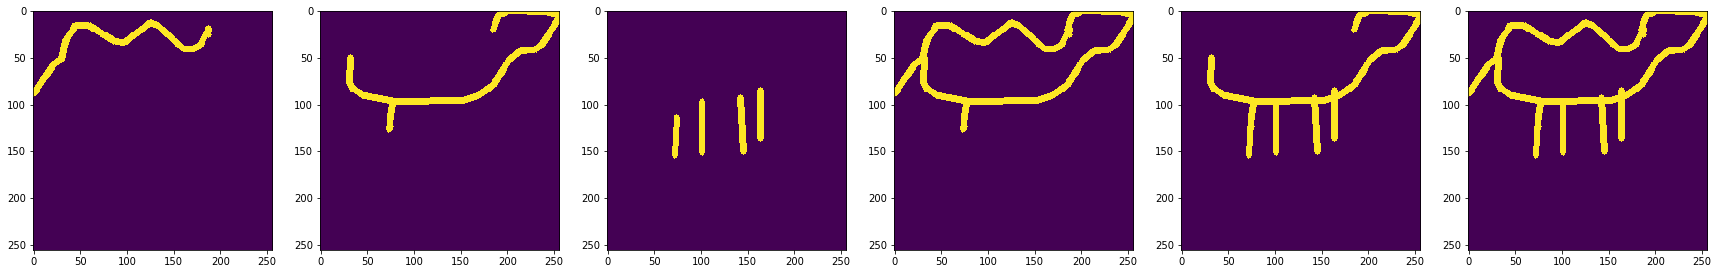

In [40]:
fig, axes = plt.subplots(1,6, figsize=(30, 30))
for i, part in enumerate(parts):
    axes[i].imshow(part)

In [71]:
def create_channels(input_list, **kwargs):
    return list2drawing(input_list, lw=5, time_color=False, **kwargs)   

def list2multichannel(input_list, **kwargs):
    if len(input_list) == 1:
        parts = [create_channels(input_list, **kwargs)]*6
    else:
        if len(input_list) == 2:
            inp1, inp2 = [input_list[0]], [input_list[1]]
            part1 = create_channels(inp1, **kwargs)
            part2 = create_channels(inp2, **kwargs)
            part3 = np.zeros((kwargs['size'], kwargs['size']))
            part4 = create_channels(inp1+inp2, **kwargs)
            part5 = create_channels(inp2, **kwargs) + part3
            part6 = create_channels(inp1+inp2, **kwargs) + part3
            parts = [part1, part2, part3, part4, part5, part6]

        else:
            div, mod = divmod(len(input_list), 3)
            inp1, inp2, inp3 = input_list[:div], input_list[div*1:div*2], input_list[div*2:div*3+mod]
            part1 = create_channels(inp1, **kwargs)
            part2 = create_channels(inp2, **kwargs)
            part3 = create_channels(inp3, **kwargs)
            part4 = create_channels(inp1+inp2, **kwargs)
            part5 = create_channels(inp2+inp3, **kwargs)
            part6 = create_channels(inp1+inp2+inp3, **kwargs)
            parts = [part1, part2, part3, part4, part5, part6]
    return np.array(parts)

In [72]:
def create_func(item):
    with open(item) as f: item = f.read()
    img = list2multichannel(eval(item), size=225)
    tensor = torch.from_numpy(img).float()
    return tensor.div_(255)

In [45]:
item_list = ItemList.from_folder(PATH/"train_folders", create_func=create_func)

In [46]:
item_list[0].shape

torch.Size([6, 225, 225])

In [47]:
np.random.seed(42)
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]
item_lists = item_list.split_by_idx(val_idxs)

In [48]:
label_lists = item_lists.label_from_folder()

In [49]:
def test_create_func(item):
    img = list2multichannel(eval(item[0]), size=225)
    tensor = torch.from_numpy(img).float()
    return tensor.div_(255)

In [50]:
test_items = ItemList.from_df(test_df, cols=['drawing', 'key_id'], create_func=create_func)

In [51]:
label_lists.add_test(test_items);

In [73]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=8)
valid_dl = DataLoader(label_lists.valid, bs, False, num_workers=8)
test_dl = DataLoader(label_lists.test, bs, False, num_workers=8)

data_bunch = DataBunch(train_dl, valid_dl, test_dl)

### Model

In [74]:
x,y = data_bunch.train_ds[0]

In [75]:
x.shape

torch.Size([6, 225, 225])

In [76]:
def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, pad=0)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=pad),
        nn.BatchNorm2d(nf),
        nn.ReLU())

In [77]:
class SketchNet(nn.Module):
    def __init__(self, num_classes=340):
        super(SketchNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv1 = conv_layer(6, 64, 15, stride=3, pad=0)
        self.conv2 = conv_layer(64, 128, 5, stride=1, pad=0)
        self.conv3 = conv_layer(128, 256, 3, stride=1, pad=1)
        self.conv4 = conv_layer(256, 256, 3, stride=1, pad=1)
        self.conv5 = conv_layer(256, 256, 3, stride=1, pad=1)
        self.conv6 = nn.Conv2d(256, 512, 7, stride=1)
        self.conv7 = nn.Conv2d(512, 512, 1, stride=1)
        self.conv8 = nn.Conv2d(512, num_classes, 1, stride=1)        
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.maxpool(self.conv1(x))
        x = self.maxpool(self.conv2(x))
        x = self.maxpool(self.conv5(self.conv4(self.conv3(x))))
        x = self.drop1(F.relu(self.conv6(x)))
        x = self.drop2(F.relu(self.conv7(x)))
        x = self.conv8(x)
        return x.view(x.shape[0], -1)

In [78]:
model = SketchNet()

In [79]:
learn = Learner(data_bunch, model, metrics=[accuracy, map3])

### Train

In [231]:
learn.lr_find(end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


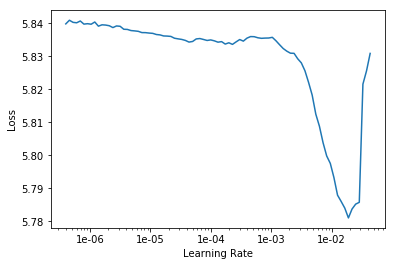

In [232]:
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(1,max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,map3



KeyboardInterrupt



In [81]:
name = "sketch-a-net"
learn.save(f'{name}-stage-1')

In [82]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 24:25
epoch  train_loss  valid_loss  accuracy  map3    
1      1.448672    1.383536    0.658706  0.739206  (04:04)
2      1.358841    1.285606    0.681059  0.757471  (04:04)
3      1.165717    1.180751    0.707647  0.780500  (04:04)
4      0.927250    1.081052    0.732294  0.800314  (04:03)
5      0.639683    1.044819    0.744294  0.810804  (04:03)
6      0.454999    1.067124    0.744647  0.810461  (04:03)



In [26]:
learn.save(f'{name}-stage-2')

### Predict

In [94]:
from utils import create_submission

In [42]:
learn.load(f'{name}-stage-1');

In [46]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [96]:
def top_3_preds(preds): return np.argsort(preds.numpy())[:, ::-1][:, :3]

def top_3_pred_labels(preds, classes):
    top_3 = top_3_preds(preds)
    labels = []
    for i in range(top_3.shape[0]):
        labels.append(' '.join([classes[idx].replace(" ", "_") for idx in top_3[i]]))
    return labels

def create_submission(test_preds, test_dl, name):
    key_ids = [item[1] for item in test_dl.dataset.x.items]
    labels = top_3_pred_labels(test_preds, classes)
    sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
    sub.to_csv(f'../data/quickdraw/submission/{name}.csv.gz', index=False, compression='gzip')

classes = data_bunch.classes

In [104]:
name = "stage-1-submission"

In [97]:
create_submission(preds, data_bunch.test_dl, "{name})

In [98]:
pd.read_csv(PATH/f'/submission/{name}.csv.gz').head(10)

,key_id,word
0,9000003627287624,radio stereo hot_tub
1,9000010688666847,sandwich hockey_puck hamburger
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent The_Eiffel_Tower
4,9000052667981386,fireplace campfire chandelier
5,9000057427034623,fence bridge spreadsheet
6,9000065506980882,wine_glass hourglass floor_lamp
7,9000087586309806,submarine arm crocodile
8,9000092580281382,campfire lobster arm
9,9000096661653918,hourglass wine_glass vase


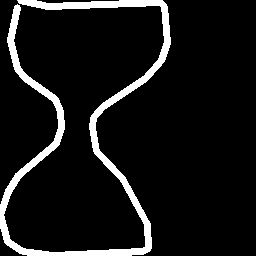

In [100]:
data_bunch.test_ds[9][0]

In [111]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f '{PATH}/submission/{name}.csv.gz' -m "{name}"

100%|██████████████████████████████████████| 1.46M/1.46M [00:01<00:00, 1.02MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge